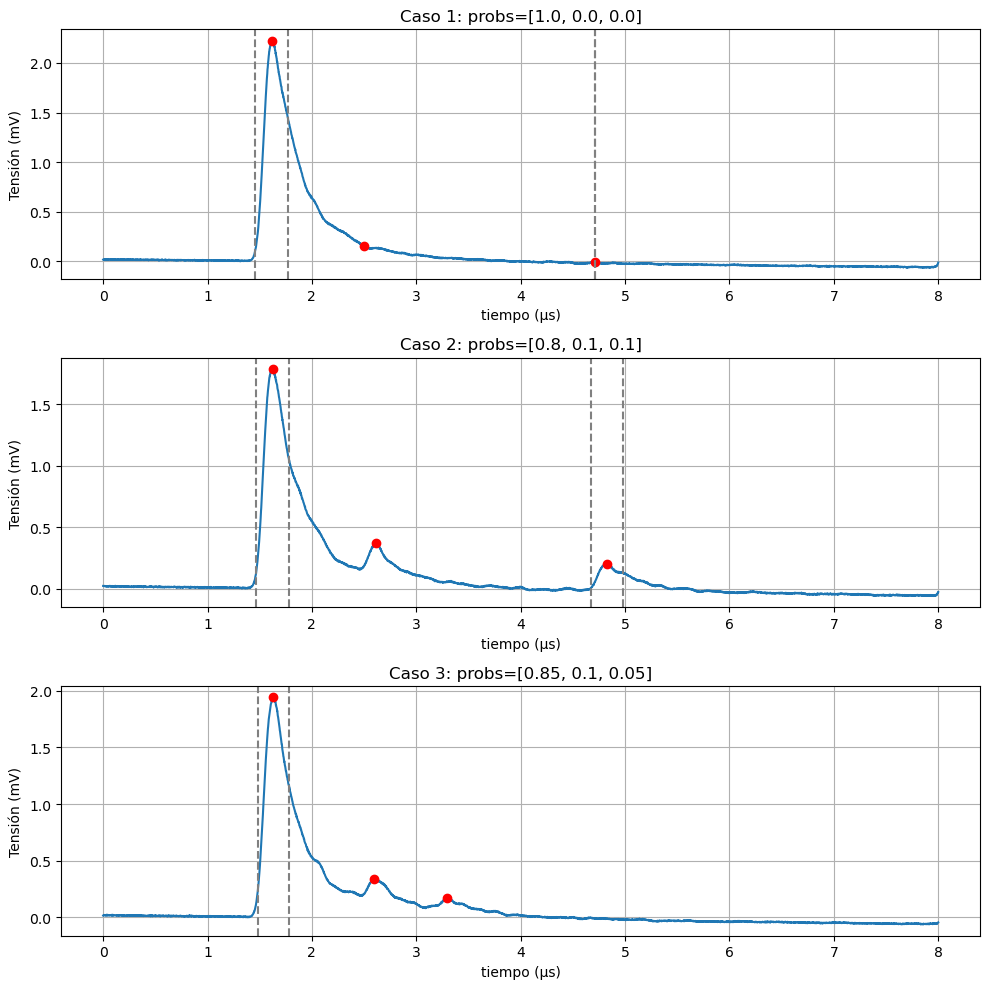


Áreas estimadas para cada pico en cada caso:

| Caso | Pico 1 | Pico 2 | Pico 3 |
|------|--------|--------|--------|
| 1    | 1.000  | 1.000  | -0.037 |
| 2    | 0.813  | 0.171  | 0.082  |
| 3    | 0.868  | 0.182  | 0.091  |


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betaprime
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

# Definimos el pulso normalizado con área unitaria
def pulso(t, t0, sigma, omega):
    gauss = np.exp(-(t - t0)**2 / (2 * sigma**2))
    seno = np.cos(omega * (t - t0 + sigma))
    S = gauss * seno
    area = np.trapz(S, t)
    if np.abs(area) < 1e-10:
        return np.zeros_like(t)
    A = 1 / area
    return A * S


def simular_medicion(t, t0s, probs, sigma0=0.05, sigma_sigma=0.005, omega0=5*np.pi, sigma_omega=0.05):
    señal = np.zeros_like(t)
    for t0, p in zip(t0s, probs):
        if np.random.rand() < p:
            # Si la probabilidad es mayor que 0, se genera el pico
            x = betaprime.rvs(a=4, b=2)
            t_centro = t0 + (x - 4 / 2) * 0.15  # media aproximada ≈ a/(b-1) si b>1
            sigma = np.random.normal(sigma0, sigma_sigma)
            omega = np.random.normal(omega0, sigma_omega)
            señal += pulso(t, t_centro, sigma, omega)
    # Agregar ruido y fondo
    ruido_rel = np.random.normal(1, 0.1, size=t.shape)
    ruido_abs = np.random.normal(0, 0.2, size=t.shape)
    fondo = (-t + 2) / 100
    return señal * ruido_rel + ruido_abs + fondo


# Simula N mediciones
def simular_N_mediciones(N, t, t0s, probs):
    return np.array([simular_medicion(t, t0s, probs) for _ in range(N)])

# Calcula máximo y FWHM
def max_y_fwhm(t, y):
    idx_max = np.argmax(y)
    y_max = y[idx_max]
    t_max = t[idx_max]
    half_max = y_max / 2

    # Buscamos a la izquierda del máximo
    left_candidates = np.where(y[:idx_max] < half_max)[0]
    if len(left_candidates) == 0:
        return t_max, y_max, np.nan
    idx_left = left_candidates[-1]

    # Buscamos a la derecha del máximo
    right_candidates = np.where(y[idx_max:] < half_max)[0]
    if len(right_candidates) == 0:
        return t_max, y_max, np.nan
    idx_right = idx_max + right_candidates[0]

    fwhm = t[idx_right] - t[idx_left]
    return t_max, y_max, fwhm


# Modelo de pico interpolado basado en caso P = [1, 0, 0]
def construir_modelo(t, y):
    return interp1d(t, y, bounds_error=False, fill_value=0)

# Ajuste de un solo pico desplazado y escalado
def ajustar_pico(t, y_exp, modelo_interp, t0_guess):
    def modelo(t, t0, A):
        return A * modelo_interp(t - (t0 - t_modelo0))
    def error(params):
        t0, A = params
        return y_exp - modelo(t, t0, A)
    t_modelo0 = t[np.argmax(modelo_interp(t))]  # centro del modelo original
    res = least_squares(error, x0=[t0_guess, 1])
    t0_fit, A_fit = res.x
    return t0_fit, A_fit

# Genera los tres casos
t = np.linspace(0, 8, 4000)
casos = [
    ([1.8, 2.8, 5], [1.0, 0.0, 0.0]),
    ([1.8, 2.8, 5], [0.8, 0.1, 0.1]),
    ([1.8, 2.8, 3.5], [0.85, 0.1, 0.05]),
]

# Simula y analiza cada caso
resultados = []
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, (t0s, probs) in enumerate(casos):
    mediciones = simular_N_mediciones(10000, t, t0s, probs)
    prom = np.mean(mediciones, axis=0)
    axs[i].plot(t, prom, label="Promedio")
    axs[i].set_title(f"Caso {i+1}: probs={probs}")
    axs[i].set_xlabel("tiempo (μs)")
    axs[i].set_ylabel("Tensión (mV)")
    axs[i].grid(True)
    
    datos_picos = []
    for t0 in t0s:
        idx_min = np.abs(t - (t0 - 0.3)).argmin()
        idx_max = np.abs(t - (t0 + 0.3)).argmin()
        t_local = t[idx_min:idx_max]
        y_local = prom[idx_min:idx_max]
        t_max, y_max, fwhm = max_y_fwhm(t_local, y_local)
        axs[i].plot(t_max, y_max, 'ro')
        axs[i].axvline(t_max - fwhm/2, ls='--', color='gray')
        axs[i].axvline(t_max + fwhm/2, ls='--', color='gray')
        datos_picos.append((t_max, fwhm))
    resultados.append((prom, datos_picos))
plt.tight_layout()
plt.show()

# Ajuste y estimación de área con base en caso 1 como plantilla
modelo_base = construir_modelo(t, resultados[0][0])
tabla = []

for i, (prom, datos_picos) in enumerate(resultados):
    fila = []
    for t0_est, _ in datos_picos:
        t0_fit, A_fit = ajustar_pico(t, prom, modelo_base, t0_est)
        fila.append(f"{A_fit:.3f}")
    tabla.append(fila)

# Mostrar tabla de áreas estimadas
print("\nÁreas estimadas para cada pico en cada caso:\n")
print("| Caso | Pico 1 | Pico 2 | Pico 3 |")
print("|------|--------|--------|--------|")
for i, fila in enumerate(tabla):
    print(f"| {i+1:<4} | {fila[0]:<6} | {fila[1]:<6} | {fila[2]:<6} |")
